In [8]:
import os
from dotenv import load_dotenv
load_dotenv()
from langchain.chat_models import init_chat_model
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

llm=init_chat_model("groq:llama-3.1-8b-instant")

In [9]:
llm.invoke("hi how are u ")

AIMessage(content="I'm just a language model, so I don't have feelings or emotions like humans do. I'm functioning properly, though. How can I assist you today?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 40, 'total_tokens': 74, 'completion_time': 0.044513319, 'completion_tokens_details': None, 'prompt_time': 0.001836513, 'prompt_tokens_details': None, 'queue_time': 0.045594671, 'total_time': 0.046349832}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f757f4b0bf', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c3d9b-5b98-7002-b821-096b3212fc49-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 40, 'output_tokens': 34, 'total_tokens': 74})

In [10]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages:Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [11]:
def Chatbot(state:State):
    return {"messages": [llm.invoke(state["messages"])]}


from langchain_tavily import TavilySearch
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
tool = TavilySearch(max_results=3, tavily_api_key=TAVILY_API_KEY)
tool.invoke("What is the capital of France?")

{'query': 'What is the capital of France?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://en.wikipedia.org/wiki/List_of_capitals_of_France',
   'title': 'List of capitals of France - Wikipedia',
   'content': 'The capital of France has been Paris since its liberation in 1944.',
   'score': 0.9996673,
   'raw_content': None},
  {'url': 'https://home.adelphi.edu/~ca19535/page%204.html',
   'title': 'Paris facts: the capital of France in history',
   'content': 'Paris is the capital of France, the largest country of Europe with 550 000 km2 (65 millions inhabitants). Paris has 2.234 million inhabitants end 2011.',
   'score': 0.9967013,
   'raw_content': None},
  {'url': 'https://www.youtube.com/shorts/uZdw9T3b_AM',
   'title': 'What is the Capital of France? - YouTube',
   'content': "Think You're a Know- It-All? Take This General Knowledge Quiz # 1 || #generalknowledge #g#gkquiz. What is the Capital of France? 56. Dislike.",
   'score': 0.994

In [12]:
def multiply(x,y):
    """ Multiplies two numbers together. 
        Args:
            x: The first number.    
            y: The second number.
        Returns:
            The product of x and y.    
    """
    return x*y

In [13]:
tools=[tool,multiply]


In [14]:
llm_with_tools=llm.bind_tools(tools)

In [15]:
## State graph with tools

from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


# tool node
graph_builder.add_node("tools",ToolNode(tools))

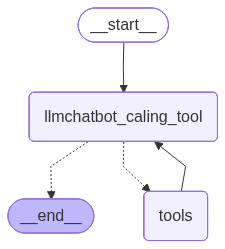

In [28]:
## create llm chatbot node - React style agent with tools
def Chatbot(state: State):
    """Process messages and invoke LLM with tools"""
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Rebuild graph from scratch
graph_builder = StateGraph(State)

# Add nodes
graph_builder.add_node("tools", ToolNode(tools))
graph_builder.add_node("llmchatbot_caling_tool", Chatbot)

# Add edges - React pattern: START -> LLM -> tools -> LLM -> END
graph_builder.add_edge(START, "llmchatbot_caling_tool")
graph_builder.add_conditional_edges("llmchatbot_caling_tool", tools_condition)
graph_builder.add_edge("tools", "llmchatbot_caling_tool")
graph_builder.add_edge("llmchatbot_caling_tool", END)

# Compile and visualize
graph = graph_builder.compile()

from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print("Graph visualization failed:", e)

In [30]:
response = graph.invoke({"messages": ["What is the current ai news and 10 multiplied by 5?"]})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is the current ai news and 10 multiplied by 5?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (fkgfk4h5p)
 Call ID: fkgfk4h5p
  Args:
    query: current ai news
    search_depth: advanced
    topic: news
  multiply (h14hpdhjv)
 Call ID: h14hpdhjv
  Args:
    x: 10
    y: 5
================================= Tool Message =================================
Name: tavily_search

{"query": "current ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://patmcguinness.substack.com/p/ai-week-in-review-260207", "title": "AI Week in Review 26.02.07 - Substack", "score": 0.7293082, "published_date": "Sat, 07 Feb 2026 23:53:11 GMT", "content": "ElevenLabs secured $500M in funding to expand AI voice generation research and infrastructure, at an $11 billion valuation, triple the prior company valuation in January

### adding memory 

In [ ]:
from langgraph.checkpoint.memory import MemorySaver

memory=MemorySaver()

## create llm chatbot node - React style agent with tools
def Chatbot(state: State):
    """Process messages and invoke LLM with tools"""
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Rebuild graph from scratch
graph_builder = StateGraph(State)

# Add nodes
graph_builder.add_node("tools", ToolNode(tools))
graph_builder.add_node("llmchatbot_caling_tool", Chatbot)

# Add edges - React pattern: START -> LLM -> tools -> LLM -> END
graph_builder.add_edge(START, "llmchatbot_caling_tool")
graph_builder.add_conditional_edges("llmchatbot_caling_tool", tools_condition)
graph_builder.add_edge("tools", "llmchatbot_caling_tool")
graph_builder.add_edge("llmchatbot_caling_tool", END)

# Compile and visualize
graph = graph_builder.compile(checkpointer=memory)

from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print("Graph visualization failed:", e)

In [ ]:
config={"configurable":{"thread":"id1"}}

### Streaming

# update and # value modes

sync and asyync 
in sync 2 modes namely 
update 
values


# human feedback loop

================================ Human Message =================================

What is the current ai news and what is 10 multiplied by 5?
================================== Ai Message ==================================
Tool Calls:
  Human_assistant (dk6vmnyrd)
 Call ID: dk6vmnyrd
  Args:
    query: Current AI news and 10 multiplied by 5
  tavily_search (8r9zdywmz)
 Call ID: 8r9zdywmz
  Args:
    query: Current AI news
    search_depth: advanced
    time_range: day
    topic: news


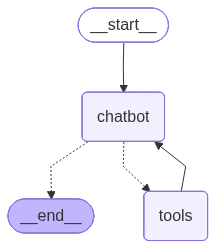

In [3]:
import os
from dotenv import load_dotenv
load_dotenv()
from langchain.chat_models import init_chat_model
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

llm=init_chat_model("groq:llama-3.1-8b-instant")

from typing import Annotated
from typing_extensions import TypedDict
from langchain_core.tools import tool

from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import interrupt
from langgraph.checkpoint.memory import MemorySaver

from langchain_tavily import TavilySearch
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
tavily_tool = TavilySearch(max_results=3, tavily_api_key=TAVILY_API_KEY)

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

@tool
def Human_assistant(query: str) -> str:
    """A tool to get human input during the conversation."""
    human_response = interrupt({"query": query})
    return human_response["data"]

tools = [tavily_tool, Human_assistant]
llm_with_tools = llm.bind_tools(tools)

def Chatbot(state: State):
    """Process messages and invoke LLM with tools"""
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", Chatbot)
graph_builder.add_node("tools", ToolNode(tools))

graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("chatbot", END)

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

config = {"configurable": {"thread_id": "1"}}
response = graph.invoke(
    {"messages": ["What is the current ai news and what is 10 multiplied by 5?"]},
    config=config
)

for m in response["messages"]:
    m.pretty_print()

from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print("Graph visualization failed:", e)

In [10]:
# Invoke response requireing human input through tool
user_query = "i need some expert guidance and assistance in understanding the current trends in artificial intelligence . could u request assistance for me ?"

response = graph.stream({"messages": [user_query]}, config=config, stream_mode="values")

for event in response:
    if "messages" in event:
        for m in event["messages"]:
            m.pretty_print()

================================ Human Message =================================

give me best resources for learning data science ,could u rrquest assistance for me ?
================================== Ai Message ==================================

Human_assistant>{"Please provide me with a list of specific areas of data science you're interested in learning (e.g., machine learning, statistics, visualization, etc.) and your current level of experience (e.g., beginner, intermediate, advanced) so I can give you more tailored recommendations."}</function>
Tool Calls:
  tavily_search (hj3k4q06j)
 Call ID: hj3k4q06j
  Args:
    query: best resources for learning data science
    search_depth: advanced
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "best resources for learning data science", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://medium.com/data-science-at-mic

# MCP server
